<a href="https://colab.research.google.com/github/NataliaDiaz/colab/blob/master/XAI_Tutorial_notebooks_Grad_CAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Grad-CAM: How to visualize class activation maps to bring Interpretability to Deep Learning

IMPORTANT: If you would like to interact with the notebook and use your own data and modify it, please first click on "File -> Save a copy in Drive" before using it

In this tutorial, you will learn how to visualize class activation maps using an algorithm called Grad-CAM (original article here: https://arxiv.org/pdf/1611.07450.pdf). It will be implemented using Keras, inspired by the code proposed by F.Chollet (https://github.com/keras-team/keras-io/blob/master/examples/vision/grad_cam.py).

Deep Learning models are considered as “black box” models as we don't know why a certain output is linked to a certain input.

As explained in the original article, "Grad-CAM uses the gradients of any target concept (say logits for “dog” or even a caption), flowing into the final convolutional layer to produce a coarse localization map highlighting the important regions in the image for predicting the concept." 

Expressed in a simpler way, we can consider that the Grad-CAM method makes it possible to know which part of the image the model looked at to make its decision, or more exactly which part of the image contributed the most to its prediction.

But why would we want to visualize class activation maps in Convolutional Neural Networks? In fact, we want to be sure that the model is taking a decision for the right reason and that is does not contain any inner bias. More concretely and to take an example, we want the model to be able to detect an hippopotamus because it looks like an hippopotamus and not because there is water around it, as we want to be able to detect an hippopotamus even when there is no water. 

The concept is simple and straighforward as we are going to:

1.   find and isolate the final convolutional layer in a pre-trained deep neural network
2.   compute the gradient flowing into that layer and color its value as an heatmap 



## Setup

In [ ]:
# Usual Imports for Deep Learning
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Display
from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib.cm as cm


Configurable parameters. 
You can change these to another model. Here we are going to use the model Xception (doc here: https://keras.io/api/applications/xception/)

To get the values for last_conv_layer_name and classifier_layer_names, use model.summary() to see the names of all layers in the model.

98304/92858 [===============================] - 0s 0us/step


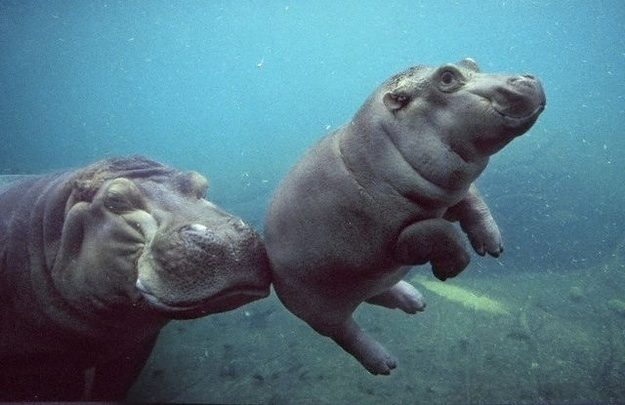

In [ ]:
model_builder = keras.applications.xception.Xception
img_size = (299, 299)
preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions

last_conv_layer_name = "block14_sepconv2_act"
classifier_layer_names = [
    "avg_pool",
    "predictions",
]

# The local path to our target image
img_path = keras.utils.get_file(
    "hippo.jpg", "https://i.imgur.com/T25JTYO.jpg"
)

display(Image(img_path))



## The Grad-CAM algorithm

In [ ]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(
    img_array, model, last_conv_layer_name, classifier_layer_names
):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

    # Second, we create a model that maps the activations of the last conv
    # layer to the final class predictions
    classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = keras.Model(classifier_input, x)

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer and make the tape watch it
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        # Compute class predictions
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    # This is the gradient of the top predicted class with regard to
    # the output feature map of the last conv layer
    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap

## Let's use it 

Predicted: [('n02398521', 'hippopotamus', 0.98483294)]


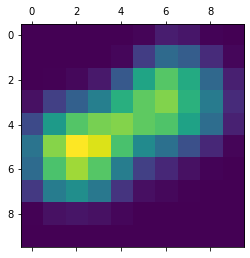

In [ ]:
# Prepare image
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# Make model
model = model_builder(weights="imagenet")

# Print what the top predicted class is
preds = model.predict(img_array)
print("Predicted:", decode_predictions(preds, top=1)[0])

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(
    img_array, model, last_conv_layer_name, classifier_layer_names
)

# Display heatmap
plt.matshow(heatmap)
plt.show()

## Create a superimposed visualization

Finally, we are going to superimpose this heatmap to the input image in order to easily visualize it

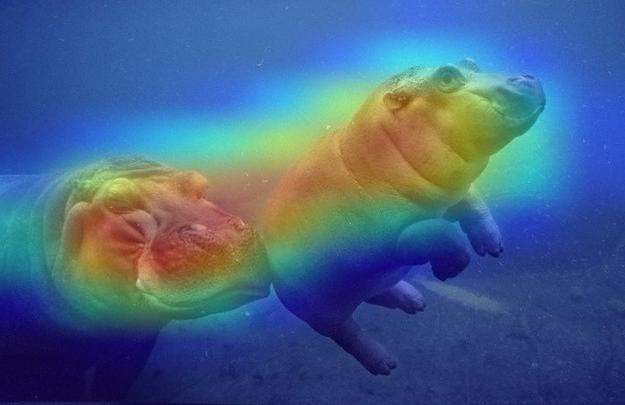

In [ ]:
# We load the original image
img = keras.preprocessing.image.load_img(img_path)
img = keras.preprocessing.image.img_to_array(img)

# We rescale heatmap to a range 0-255
heatmap = np.uint8(255 * heatmap)

# We use jet colormap to colorize heatmap
jet = cm.get_cmap("jet")

# We use RGB values of the colormap
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]

# We create an image with RGB colorized heatmap
jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

# Superimpose the heatmap on original image
superimposed_img = jet_heatmap * 0.8 + img #0.4 good value
superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

# Save the superimposed image
save_path = "hippopotamus_cam.jpg"
superimposed_img.save(save_path)

# Display Grad CAM
display(Image(save_path))

## Perfect!

Now we know that the model "looked" at the center of the image, where the head of the big hippopotamus and the back of the small one are located, in order to make its prediction. 

We can be glad we have an hippopotamus detector and not a river or lake detector! 

You can now have fun by testing this method on other images!